## smava

Dataset simplifications for question 3.

In [26]:
getwd()

## load in packages
library(tidyverse)
library(rpart.plot)

library(e1071)
library(MASS)
library(mlbench)
library(gbm)
library(kernlab)
library(RSNNS)
library(dplyr)

## last loaded, first found methods
library(caret)

## implementation
library(doMC)

registerDoMC(cores = detectCores(all.tests = FALSE, logical = TRUE))

options(useFancyQuotes = TRUE)
options(repr.plot.width=16, repr.plot.height=10)

[1] "/misc/build/0/pyeg0/caret/classr1"

In [2]:
detectCores(all.tests = FALSE, logical = TRUE)

[1] 8

In [3]:
load("bak/in/train.rdata")
load("bak/in/test.rdata")

train0 <- data.frame(train) # a local copy.
smava1 <- list()

In [4]:
cols <- colnames(train)
cols <- cols[grep('^x', cols)]
cols <- setdiff(cols, "x3")

smava1$xcols <- c(cols, "interestRate")
smava1$xcols1 <- c("x1", "x10", "x4")
smava1$xcols2 <- setdiff(cols, c("interestRate", "x6", "x7"))

In [5]:
## Not very good. Let's try a predictor specific to a bank
## List the banks.
smava1$banks <- unique(train[["bank"]])
length(smava1$banks)
smava1$banks

[1] 30

[1] B14 B4  B25 B3  B1  B8  B18 B21 B6  B15 B16 B2  B12 B27 B7  B30 B9  B22 B28
[20] B17 B26 B23 B11 B20 B19 B13 B29 B24 B5  B10
30 Levels: B1 B10 B11 B12 B13 B14 B15 B16 B17 B18 B19 B2 B20 B21 B22 ... B9

In [6]:
## Random choose a bank to look at
fidx <- function(N0, n=3) sample(1:N0, n, replace = FALSE)

t <- smava1$banks
tag <- t[fidx(length(t))]
smava1$tag <- tag[1:1]

smava1

$xcols
 [1] "x1"           "x2"           "x4"           "x5"           "x6"          
 [6] "x7"           "x8"           "x9"           "x10"          "interestRate"

$xcols1
[1] "x1"  "x10" "x4" 

$xcols2
[1] "x1"  "x2"  "x4"  "x5"  "x8"  "x9"  "x10"

$banks
 [1] B14 B4  B25 B3  B1  B8  B18 B21 B6  B15 B16 B2  B12 B27 B7  B30 B9  B22 B28
[20] B17 B26 B23 B11 B20 B19 B13 B29 B24 B5  B10
30 Levels: B1 B10 B11 B12 B13 B14 B15 B16 B17 B18 B19 B2 B20 B21 B22 ... B9

$tag
[1] B27
30 Levels: B1 B10 B11 B12 B13 B14 B15 B16 B17 B18 B19 B2 B20 B21 B22 ... B9

In [ ]:
plot(train[, smava1$xcols2])

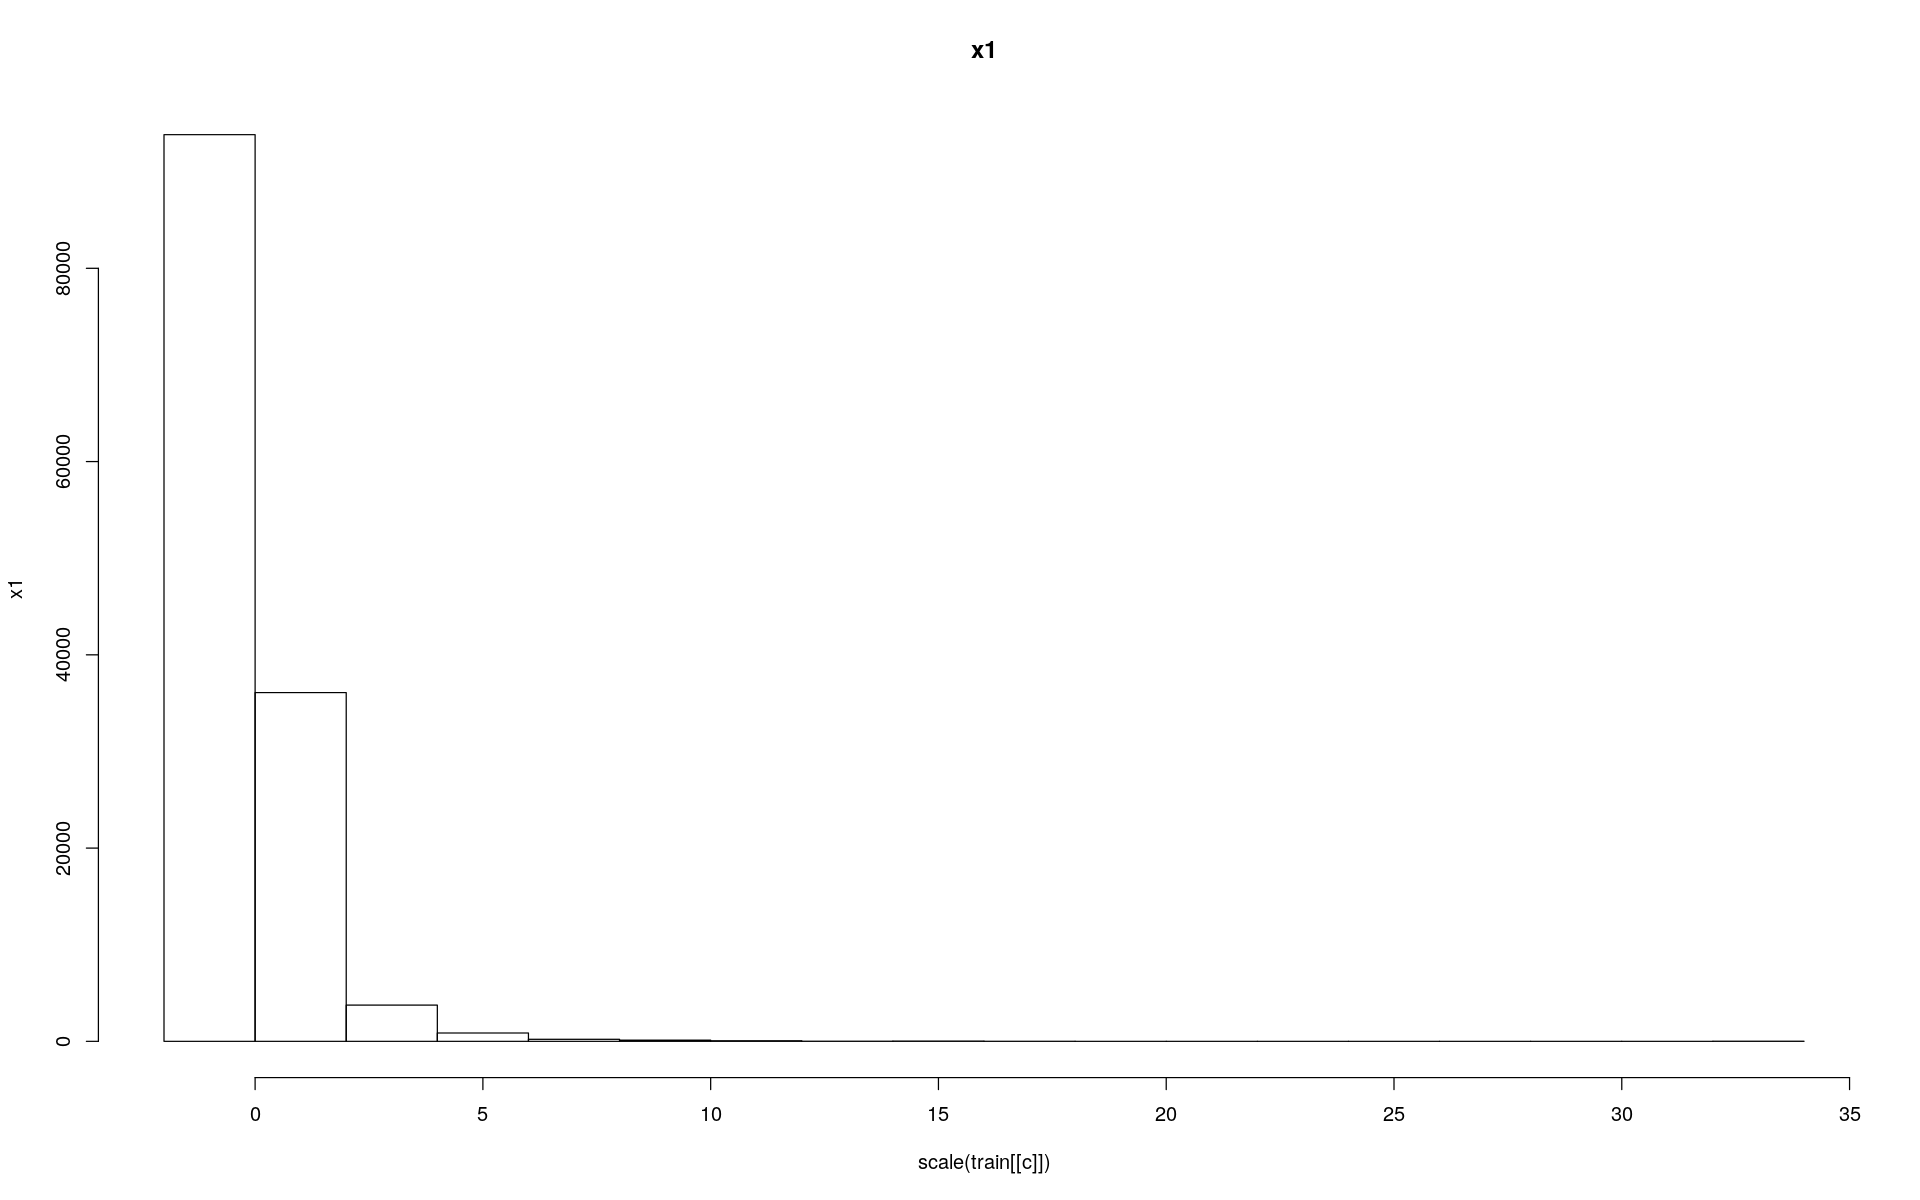

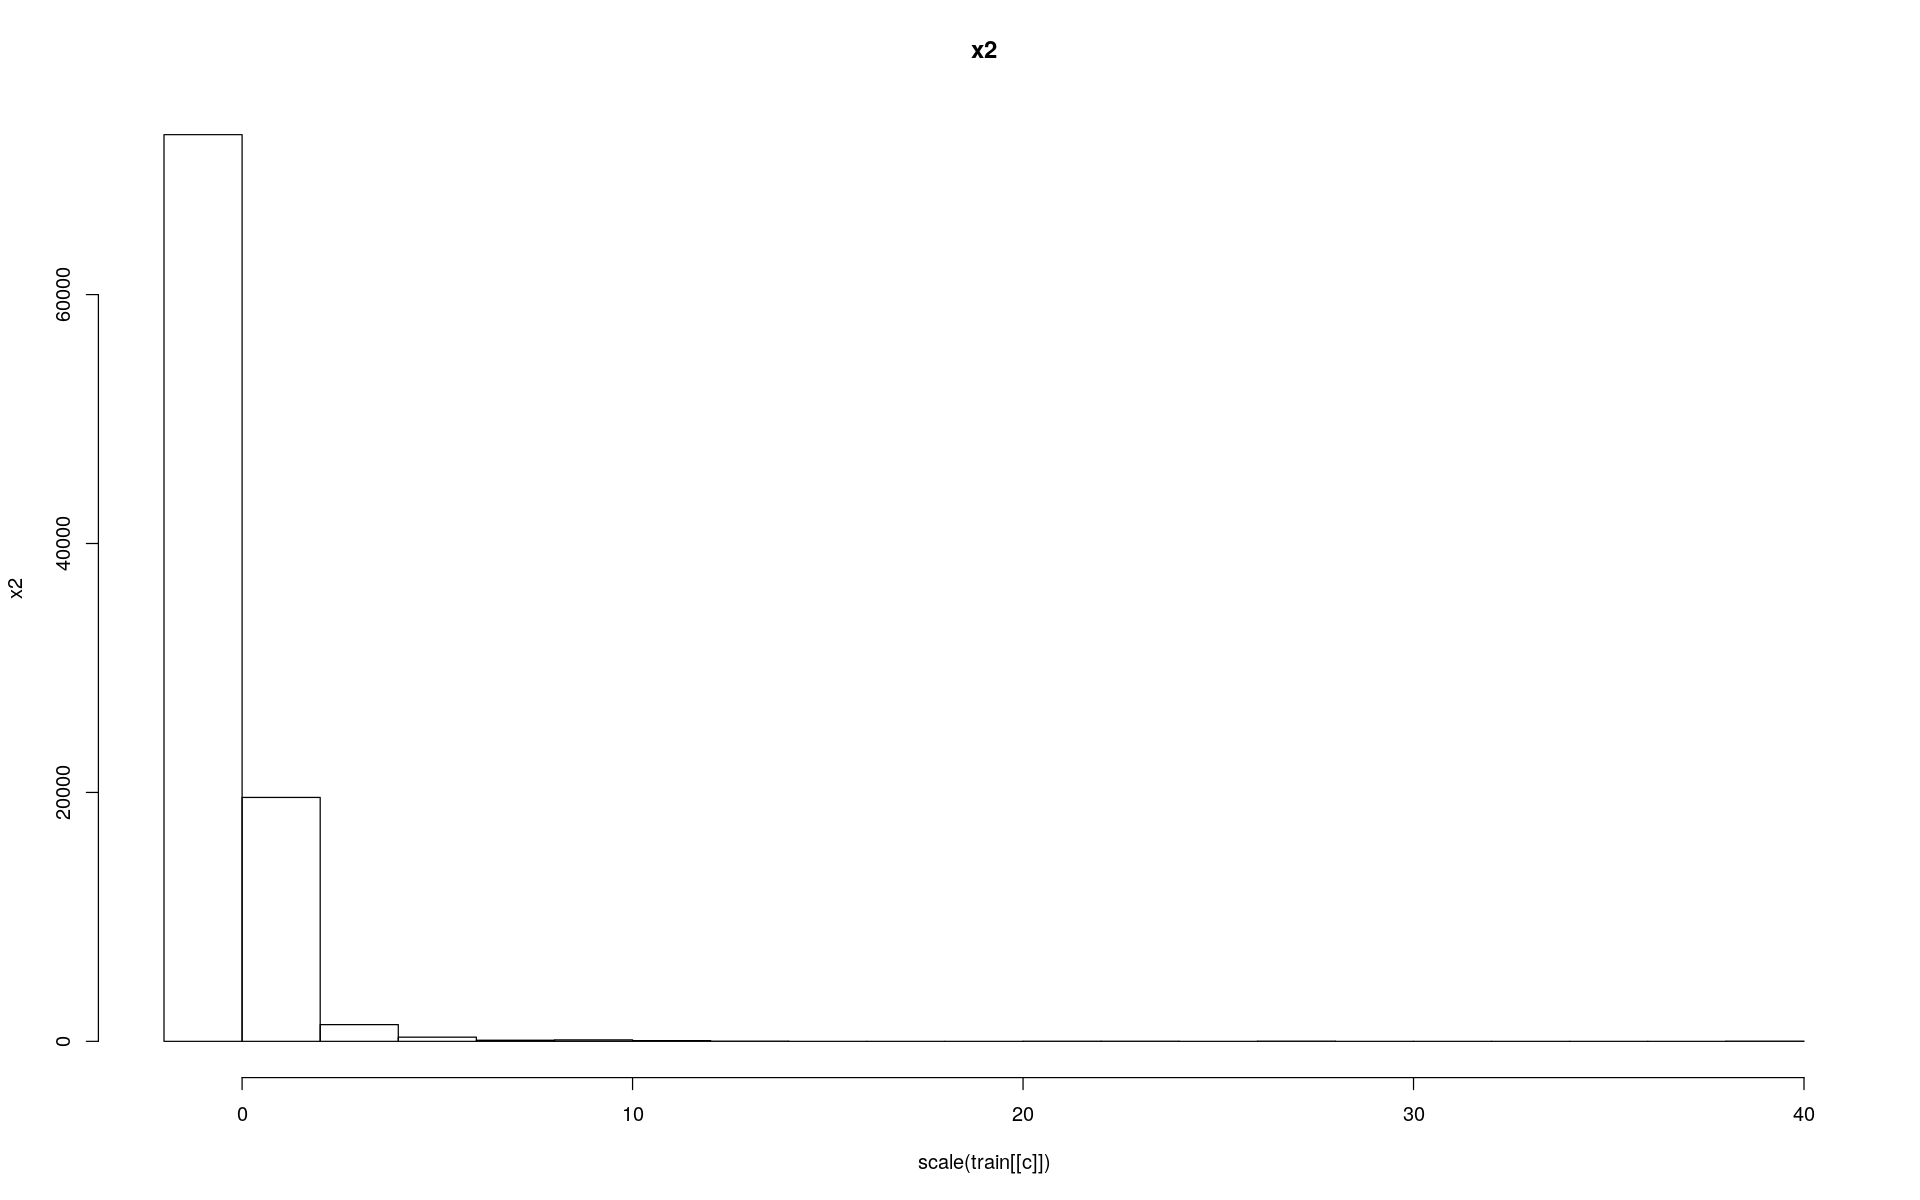

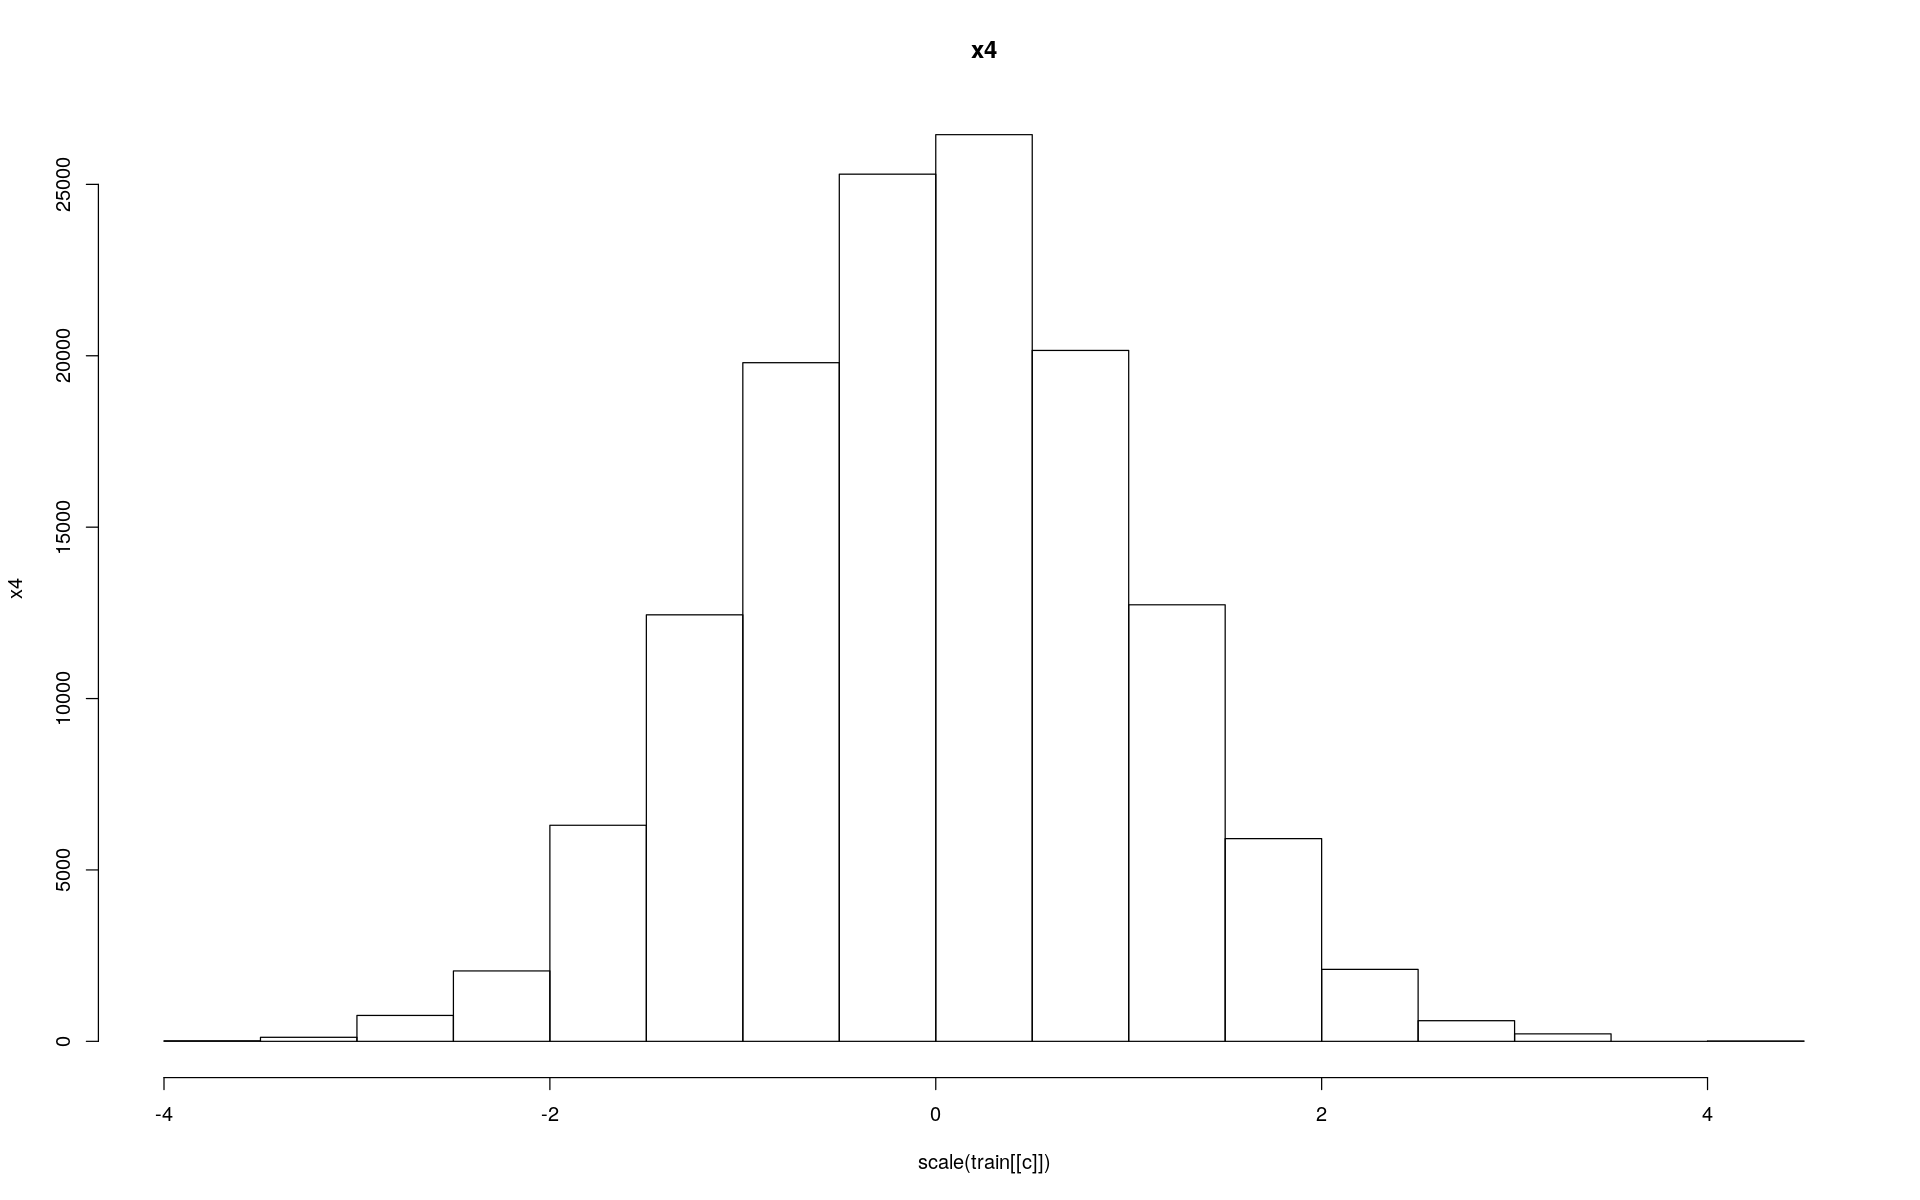

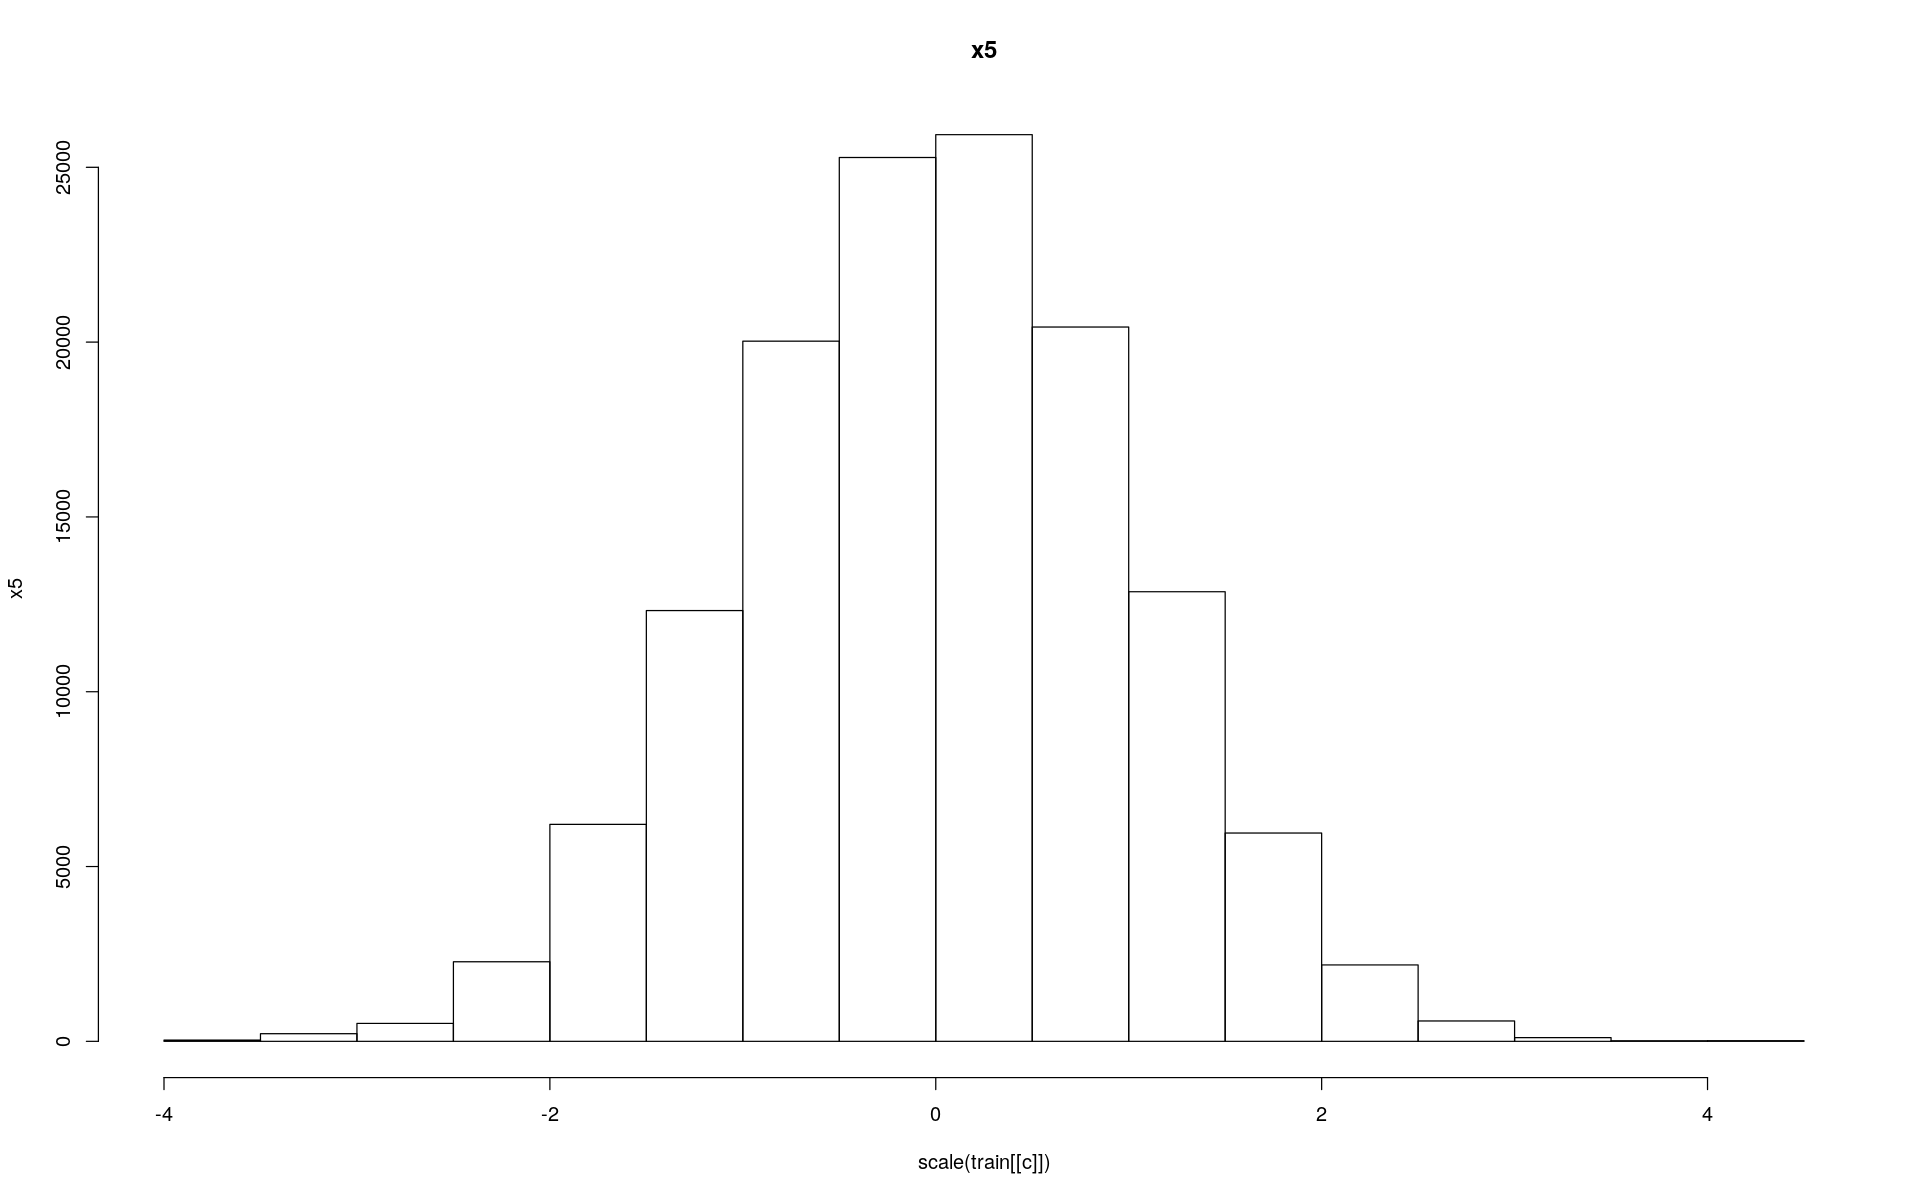

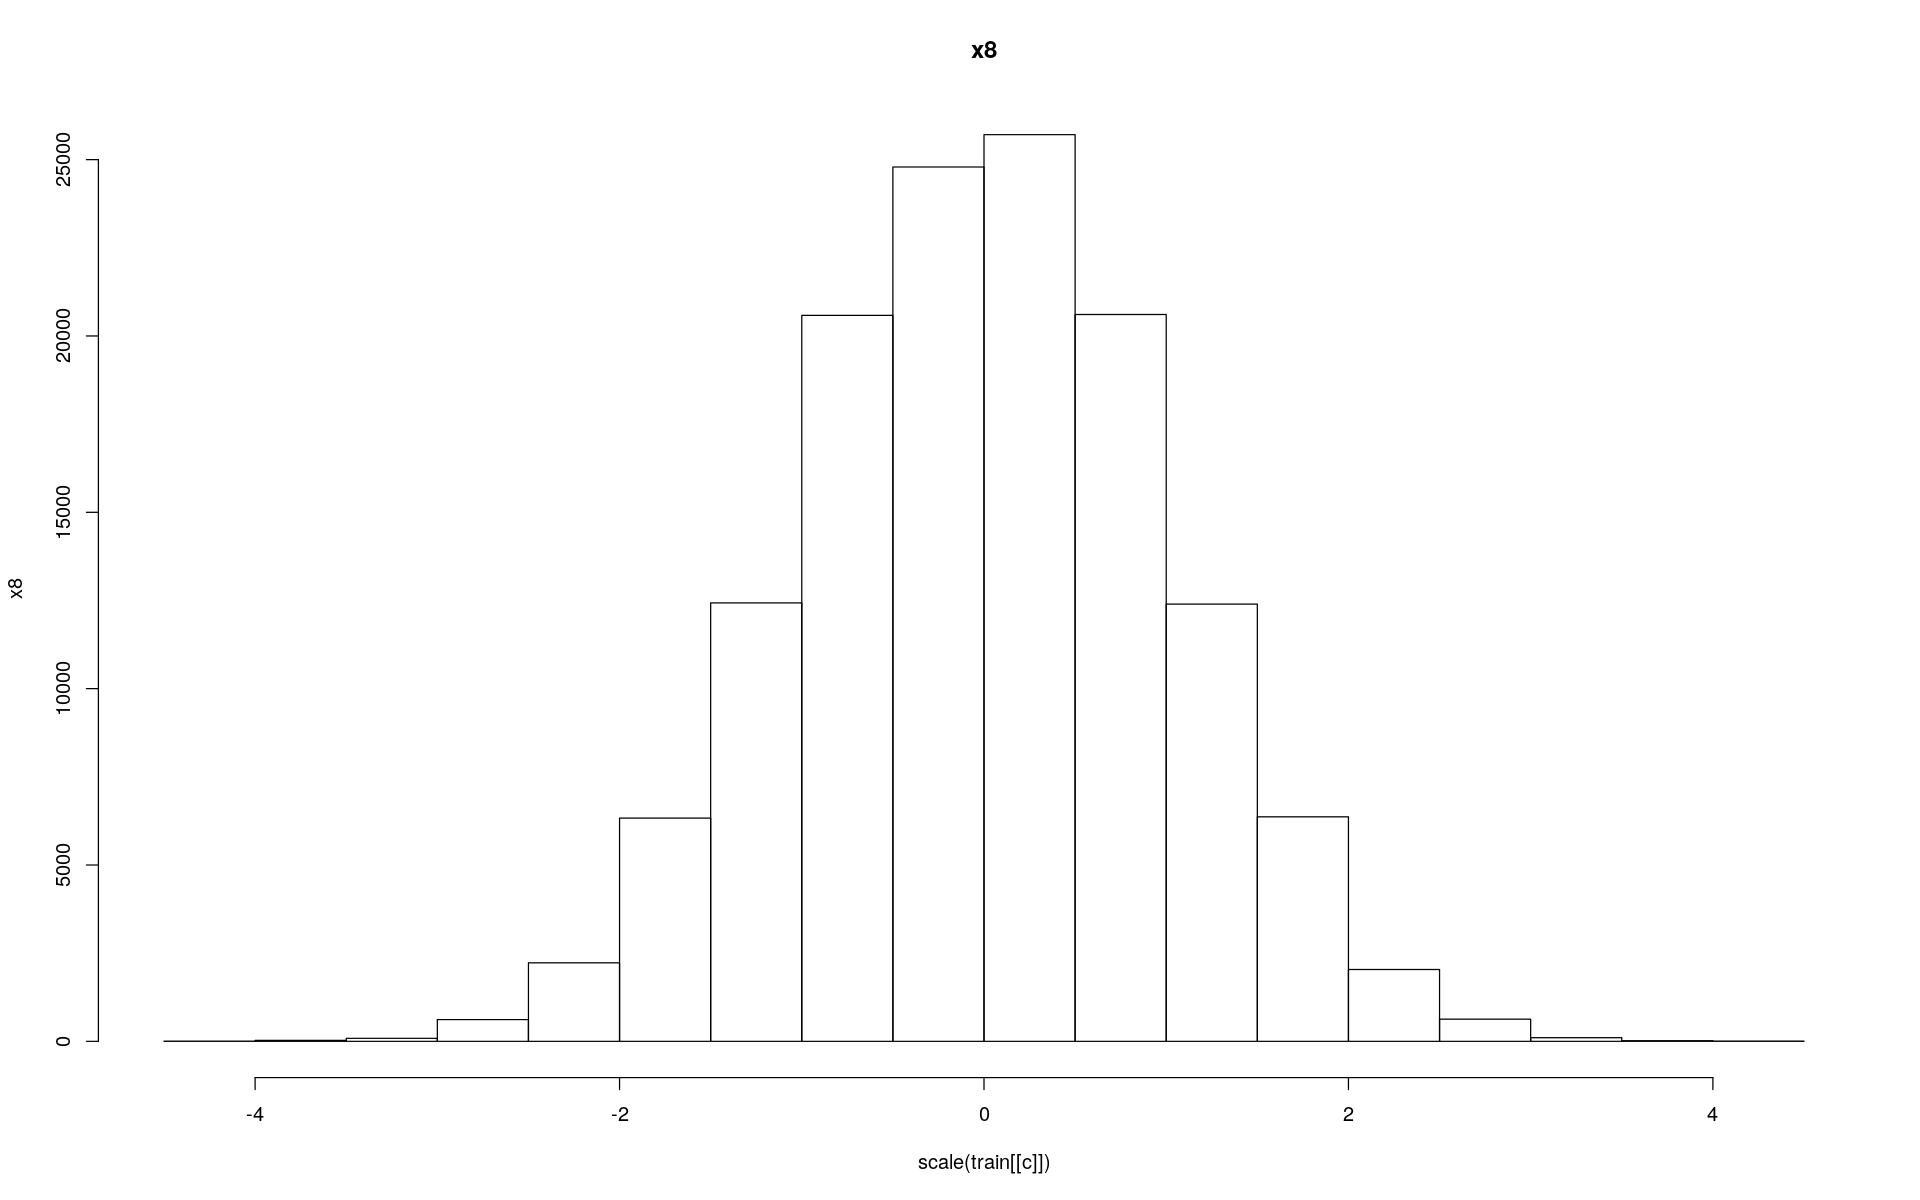

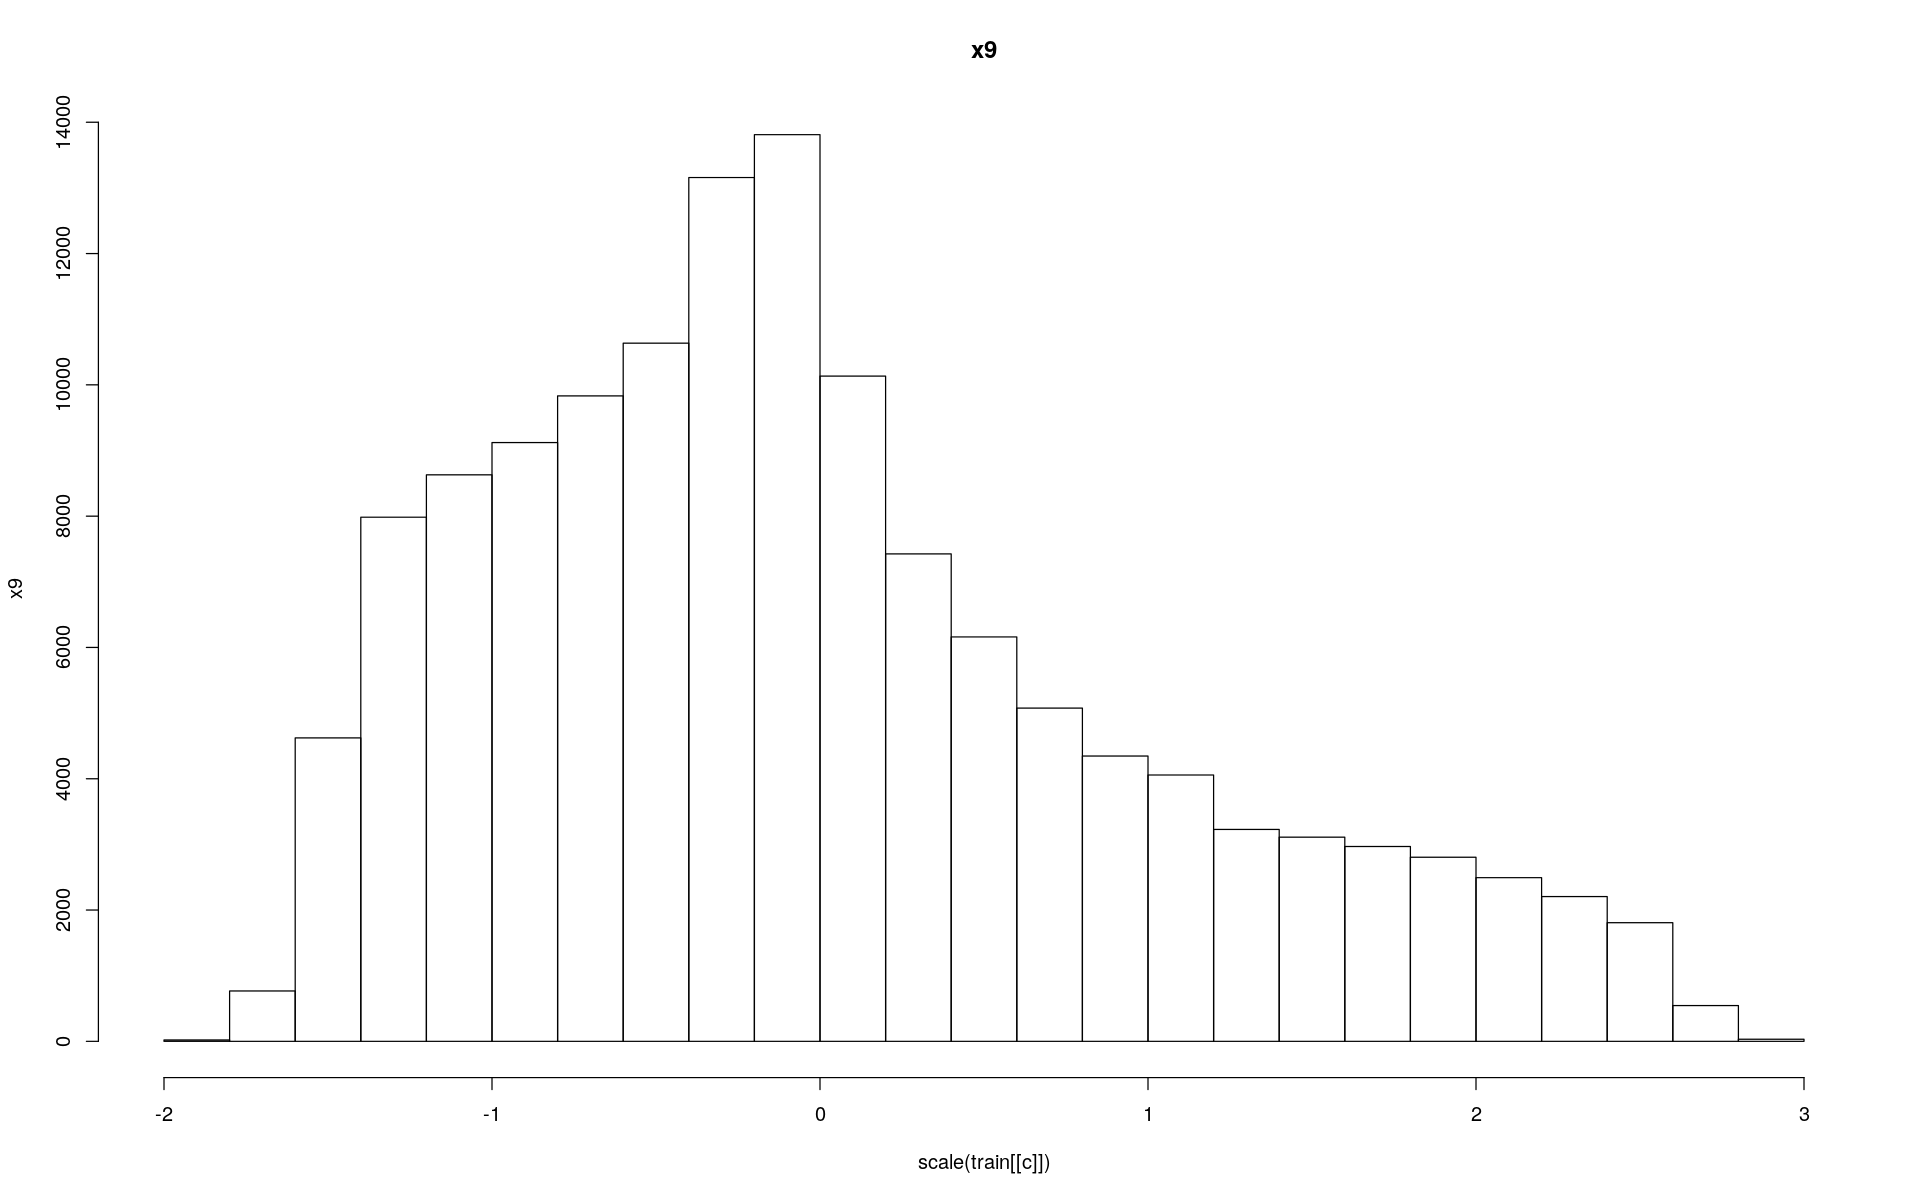

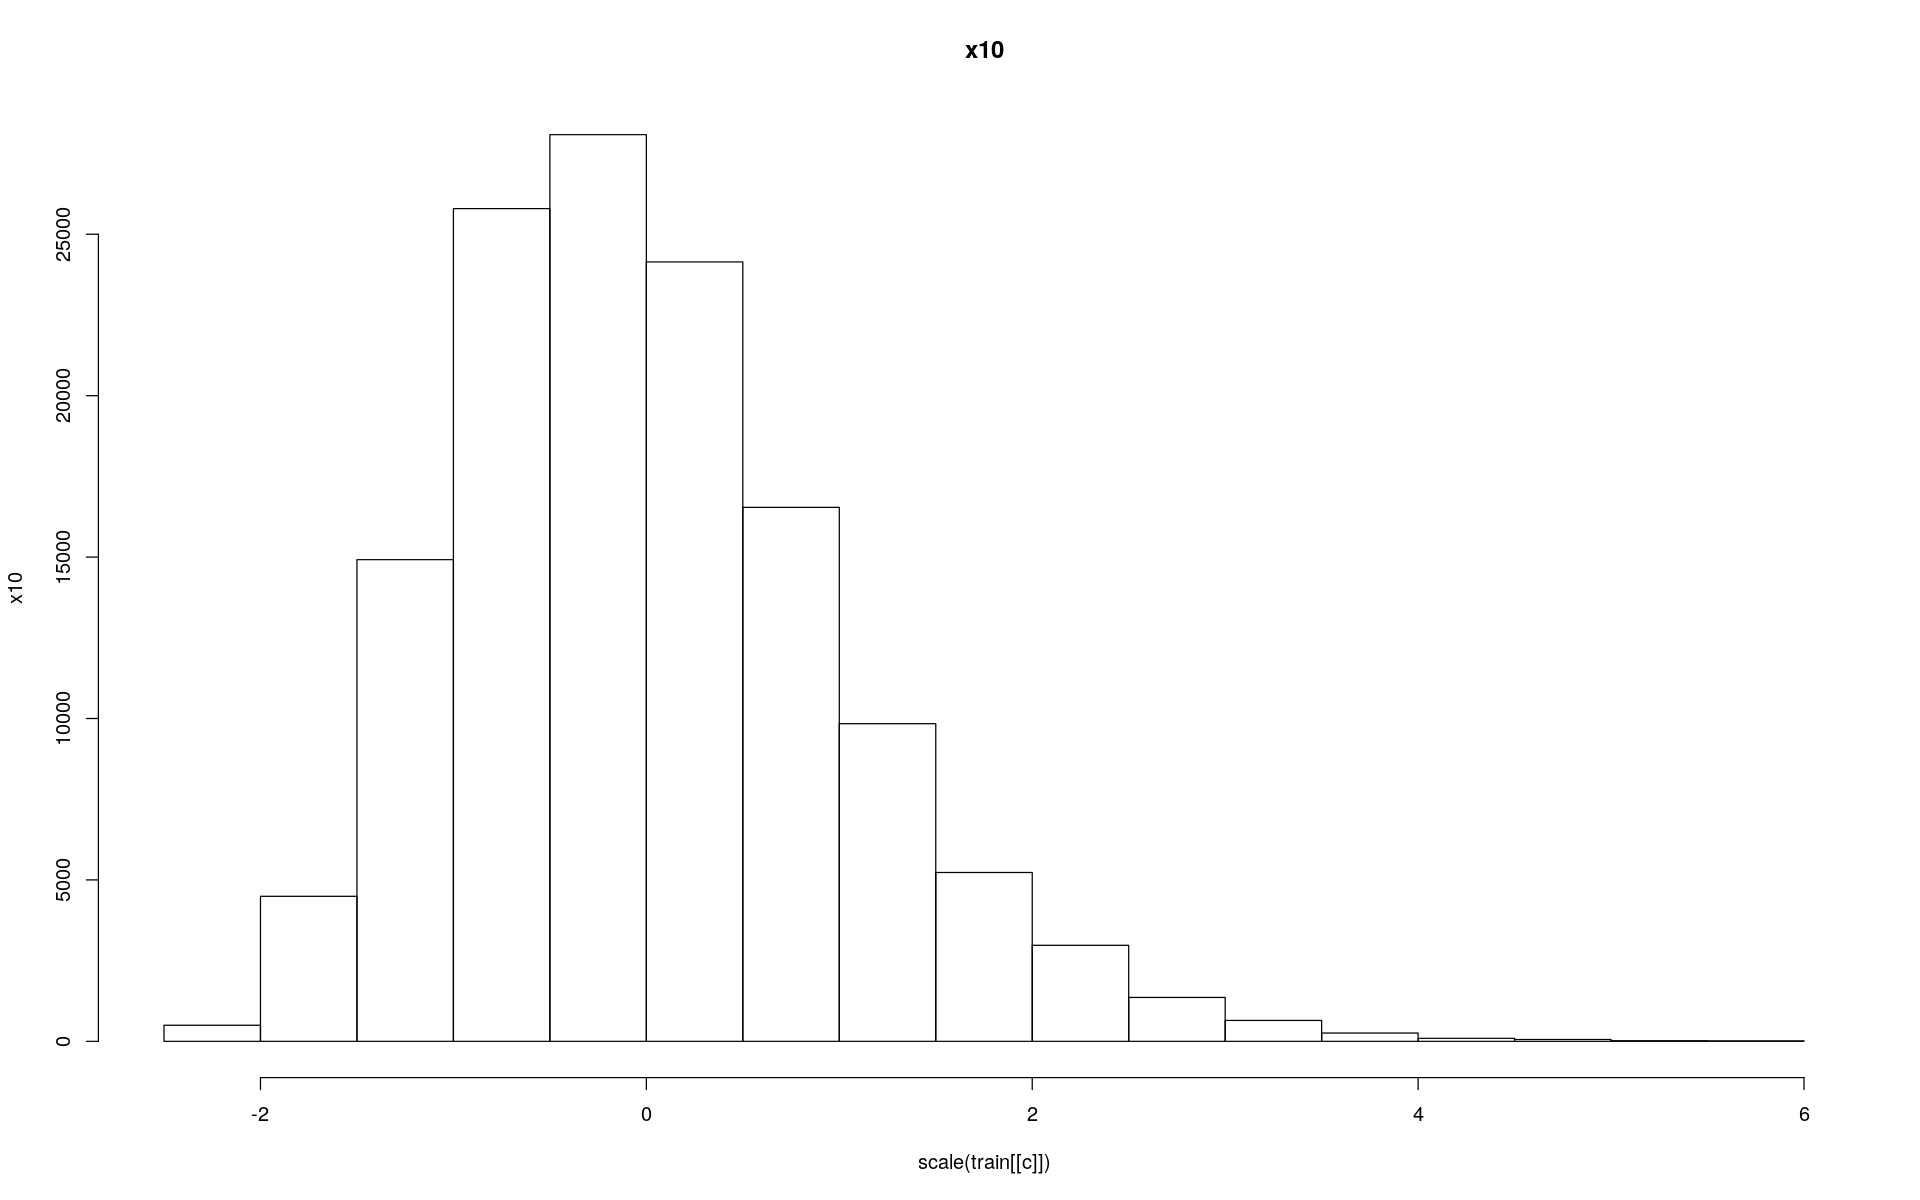

In [27]:
trellis.par.set(caretTheme())
for (c in smava1$xcols2) {
    hist(scale(train[[c]]), main = c, ylab=c)
}

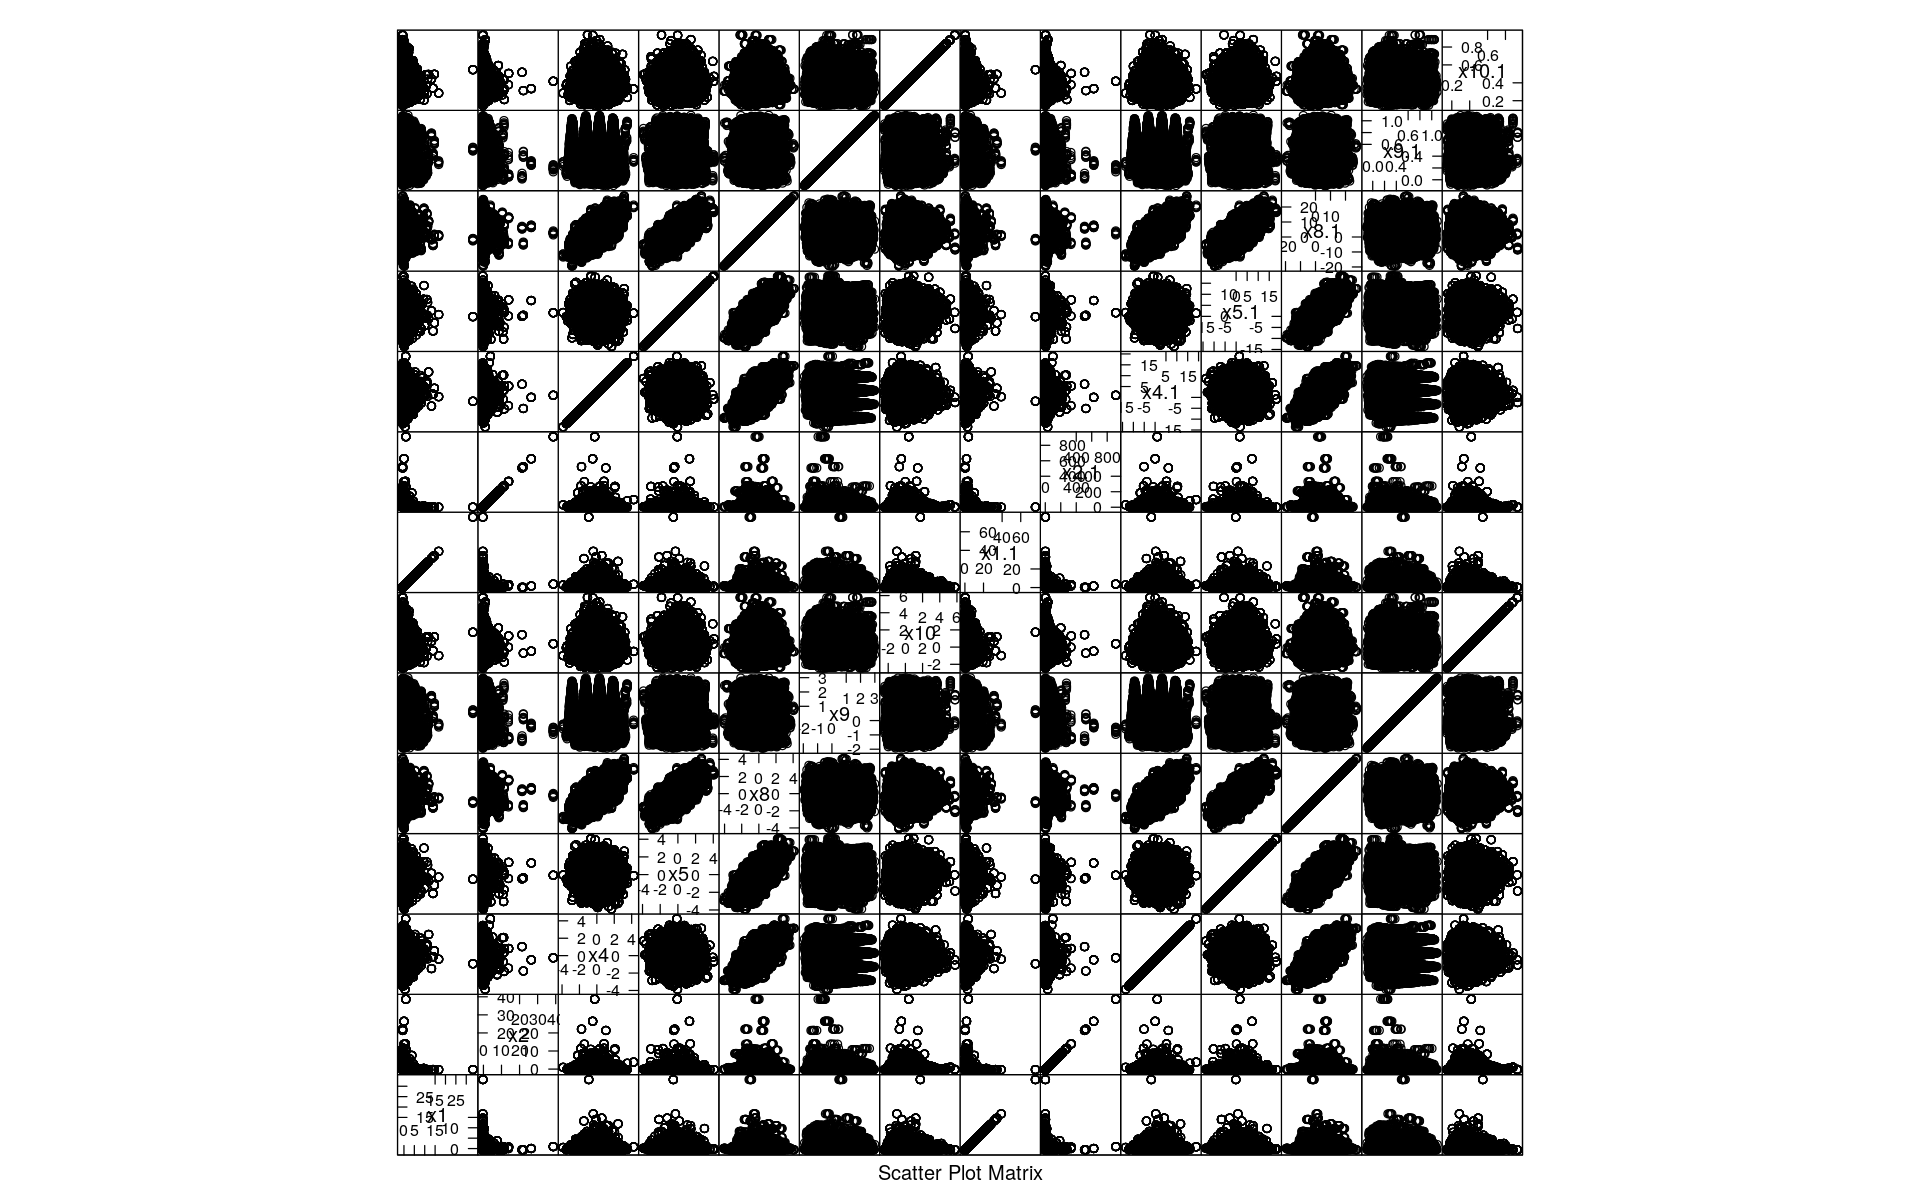

In [28]:
trellis.par.set(caretTheme())

d0 <- train[, smava1$xcols2]

featurePlot(scale(d0), d0, "pairs")

In [3]:
## Specific to a bank
## And impute x2
train1 <- train[ train$bank %in% smava1$tag, smava1$xcols]

train1$x2na <- 0
train1[is.na(train1$x2), "x2na"] <- 1

v0 <- train1[train1$x2 & train1$x2na == 0, "x2"]
v0 <- mean(v0[["x2"]])

train1[is.na(train1$x2), "x2"] <- v0

train1 <- train1[!is.na(train1$interestRate),]

dim(train1)
head(train1)

# test1[ is.na(test1$x2), "x2" ] <- smava0$x2impute

[1] 2308   11

x1,x2,x4,x5,x6,x7,x8,x9,x10,interestRate,x2na
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7602361,7.654736,0.7555276,1.4875123,ACS,HI2CR,2.403862,0.26512819,0.4771662,8.146028,0
2.1225951,104.918131,0.5179671,2.8880431,FBW,RO8CB,2.681057,0.06195821,0.5487776,4.847255,0
1.0442341,4.617027,-4.3794277,-4.6274546,FBW,UKCJW,-8.711787,0.23838372,0.3703532,3.863542,0
0.4452255,8.380616,5.9578036,2.0088755,ACS,4AME2,6.814333,0.30277202,0.3907478,3.669182,1
1.0114072,4.109274,-0.3000797,-0.5895193,ACS,P6ABK,-1.676104,0.20646726,0.4282903,4.211820,0
0.6031224,8.380616,3.6176557,5.8999026,ACS,KVLXC,9.366989,0.10618052,0.4085868,6.919550,1


## Rounding

Some rounding illustrates that we started with 15000 customers and there are 15000 distinct x1, x4, x10 configurations

if other x values are added, there are no distinct records.

5 sf is usually accurate enough.

In [45]:
sf5 <- function(x) signif(x, 5)
train2 <- train %>% dplyr::select(smava1$xcols1) %>% mutate_all(sf5)
dim(train2)

[1] 134969      3

In [46]:
train2 <- distinct(train2)
dim(train2)
head(train[, smava1$xcols1])
head(train2)
length(unique(train[["customerNumber"]]))

[1] 14999     3

x1,x10,x4
<dbl>,<dbl>,<dbl>
2.6820549,0.2702748,4.0264718
1.1749983,0.2506165,-3.2329746
1.8947994,0.3891396,2.1999443
1.7044089,0.3731034,-1.2095107
2.5554689,0.4293550,2.4950889
0.2704093,0.3314056,0.9586655


x1,x10,x4
<dbl>,<dbl>,<dbl>
2.68210,0.27027,4.02650
1.17500,0.25062,-3.23300
1.89480,0.38914,2.19990
1.70440,0.37310,-1.20950
2.55550,0.42935,2.49510
0.27041,0.33141,0.95867


[1] 14999